In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=3, suppress=True)
sns.set_theme(style='darkgrid', palette='muted', font='monospace', font_scale=1.25)

In [2]:
names = pd.read_csv('./names.csv', header=None, names=['Eldritch name'])
print(names)

# concatenate training data into a single string
names_string = '.' + '.'.join(names['Eldritch name'].tolist()) + '.'

    Eldritch name
0          'ymnar
1         abholos
2           alala
3       ammutseba
4    amon-gorloth
..            ...
180      zindarak
181    zoth-ommog
182  zstylzhemghi
183      zushakon
184   zvilpogghua

[185 rows x 1 columns]


In [3]:
def symbol_to_index(symbol):
    '''Convert symbol to index'''
    if symbol == '.':
        return 0
    elif symbol == ' ':
        return 1
    elif symbol == '-':
        return 2
    elif symbol == '\'':
        return 3
    elif 97 <= ord(symbol.lower()) <= 122:
        return ord(symbol.lower()) - 93
    else:
        return 1

def index_to_symbol(index):
    '''Convert index to symbol'''
    if index == 0:
        return '.'
    elif index == 1:
        return ' '
    elif index == 2:
        return '-'
    elif index == 3:
        return '\''
    else:
        return chr(index + 93)

def string_to_index(string):
    '''Return the list of indices that represent a string'''
    return list(map(symbol_to_index, string))

def index_to_string(indices):
    '''Return the string represented by the list of indices'''
    return ''.join(map(index_to_symbol, indices))

# validate encoding/decoding
assert names_string == index_to_string(string_to_index(names_string)),\
       'Names dataset is changed after encoding/decoding.'

In [4]:
names_encoding = string_to_index(names_string)
NUM_SYMBOLS = max(names_encoding) + 1

bigrams = np.zeros((NUM_SYMBOLS,NUM_SYMBOLS), dtype=int)
for i in range(len(names_encoding)-1):
    bigrams[names_encoding[i], names_encoding[i+1]] += 1
    
# optionally, smooth the bigram matrix
bigrams += 1
# disable combinations that should not appear
bigrams[:4,:4] = 0

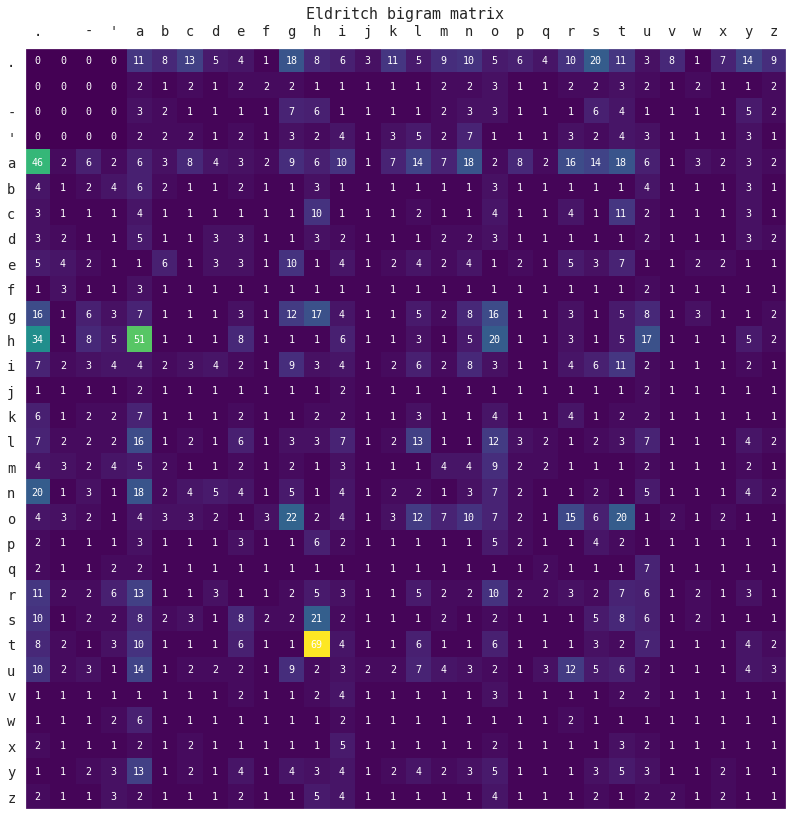

In [5]:
fig, ax = plt.subplots(figsize=(14,14))
ax.matshow(bigrams, cmap='viridis')

# annotate each cell with bigram count
for i in range(NUM_SYMBOLS):
    for j in range(NUM_SYMBOLS):
        text = ax.text(j, i, bigrams[i,j], ha="center", va="center", color="w")

# configure axis
ax.set_title('Eldritch bigram matrix')
labels = [index_to_symbol(ind) for ind in range(NUM_SYMBOLS)]
_ = ax.set_xticks(range(NUM_SYMBOLS), labels)
_ = ax.set_yticks(range(NUM_SYMBOLS), labels)
ax.tick_params(top=False, bottom=False, left=False, right=False)
ax.grid(None)

In [6]:
def generate_name(random_seed=None):
    '''Generate an Eldritch name by sampling a bigram matrix'''
    if random_seed is not None:
        np.random.seed(random_seed)
    name = [0]
    while True:
        prob = bigrams[name[-1]] / bigrams[name[-1]].sum()
        name.append(np.random.choice(range(NUM_SYMBOLS), p=prob))
        if name[-1] == 0:
            break
    return index_to_string(name[1:-1])

In [7]:
seeds = [5, 1025, 2005, 55, 555]
for seed in seeds:
    print(generate_name(random_seed=seed))

gtevkmomb'cth
qqghan
ewarthoroalonchyu-gthuakaii
cyicogt
s
